In [1]:
# ===============================
# STEP 1: IMPORT LIBRARIES
# ===============================
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)


2025-10-27 22:46:11.590601: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761605172.013497      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761605172.133826      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# ===============================
# STEP 2: LOAD PREPROCESSED DATA
# ===============================
X_train = np.load('/kaggle/input/preprocessed-inthewild/X_train.npy')
X_val   = np.load('/kaggle/input/preprocessed-inthewild/X_val.npy')
X_test  = np.load('/kaggle/input/preprocessed-inthewild/X_test.npy')

y_train = np.load('/kaggle/input/preprocessed-inthewild/y_train.npy')
y_val   = np.load('/kaggle/input/preprocessed-inthewild/y_val.npy')
y_test  = np.load('/kaggle/input/preprocessed-inthewild/y_test.npy')

print("X_train:", X_train.shape)
print("X_val:", X_val.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_val:", y_val.shape)
print("y_test:", y_test.shape)


X_train: (22245, 128, 94, 1)
X_val: (4767, 128, 94, 1)
X_test: (4767, 128, 94, 1)
y_train: (22245,)
y_val: (4767,)
y_test: (4767,)


In [3]:
# ===============================
# STEP 3: NORMALIZATION
# ===============================
X_train = X_train.astype('float32') / np.max(X_train)
X_val   = X_val.astype('float32') / np.max(X_val)
X_test  = X_test.astype('float32') / np.max(X_test)

print("Train shape:", X_train.shape)
print("Val shape:", X_val.shape)
print("Test shape:", X_test.shape)


Train shape: (22245, 128, 94, 1)
Val shape: (4767, 128, 94, 1)
Test shape: (4767, 128, 94, 1)


In [4]:
# ===============================
# STEP 4: CNN MODEL ARCHITECTURE
# ===============================

model = Sequential([
    # Block 1
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=X_train.shape[1:]),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    # Block 2
    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.3),

    # Block 3
    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.4),

    # Dense layers
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),

    # Output layer
    Dense(1, activation='sigmoid')  # Binary classification (Real/Fake)
])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1761605212.373792      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1761605212.374462      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 94, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 94, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 47, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 23, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 23, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 22528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,883,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,977,409 (11.36 MB)

 Trainable params: 2,976,961 (11.36 MB)

 Non-trainable params: 448 (1.75 KB)

In [5]:
# ===============================
# STEP 5: COMPILE MODEL
# ===============================
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [6]:
# ===============================
# STEP 6: DEFINE CALLBACKS
# ===============================
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    patience=4,
    factor=0.5,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_cnn_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)


In [7]:
# ===============================
# STEP 7: TRAIN THE MODEL
# ===============================
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=1
)


Epoch 1/50


I0000 00:00:1761605220.834760      99 service.cc:148] XLA service 0x7a3b28014fe0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761605220.836189      99 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1761605220.836220      99 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1761605221.403275      99 cuda_dnn.cc:529] Loaded cuDNN version 90300


 10/696 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.6283 - loss: 3.1882

I0000 00:00:1761605227.887063      99 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


696/696 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9055 - loss: 0.3912
Epoch 1: val_loss improved from inf to 1.60684, saving model to best_cnn_model.keras
696/696 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - accuracy: 0.9056 - loss: 0.3909 - val_accuracy: 0.8636 - val_loss: 1.6068 - learning_rate: 5.0000e-04
Epoch 2/50
693/696 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9803 - loss: 0.0780
Epoch 2: val_loss improved from 1.60684 to 0.04434, saving model to best_cnn_model.keras
696/696 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.9803 - loss: 0.0779 - val_accuracy: 0.9924 - val_loss: 0.0443 - learning_rate: 5.0000e-04
Epoch 3/50
693/696 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9883 - loss: 0.0384
Epoch 3: val_loss improved from 0.04434 to 0.03844, saving model to best_cnn_model.keras
696/696 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.9883 - loss: 0.0384 - val_accuracy: 0.9929 - val_loss: 0.0384 - learning_rate: 5.0000e-04
Epoch 4/50
693/696 ━━━━━━━━━━━━━━━━━━━━ 0s 14m

In [8]:
# ===============================
# STEP 8: EVALUATION ON TEST SET
# ===============================
y_pred = (model.predict(X_test) > 0.5).astype("int32")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Real', 'Fake']))

cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
print("Test Accuracy:", acc)


149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Classification Report:
              precision    recall  f1-score   support

        Real       0.99      1.00      1.00      2995
        Fake       1.00      0.99      0.99      1772

    accuracy                           1.00      4767
   macro avg       1.00      0.99      1.00      4767
weighted avg       1.00      1.00      1.00      4767

Test Accuracy: 0.9960142647367317


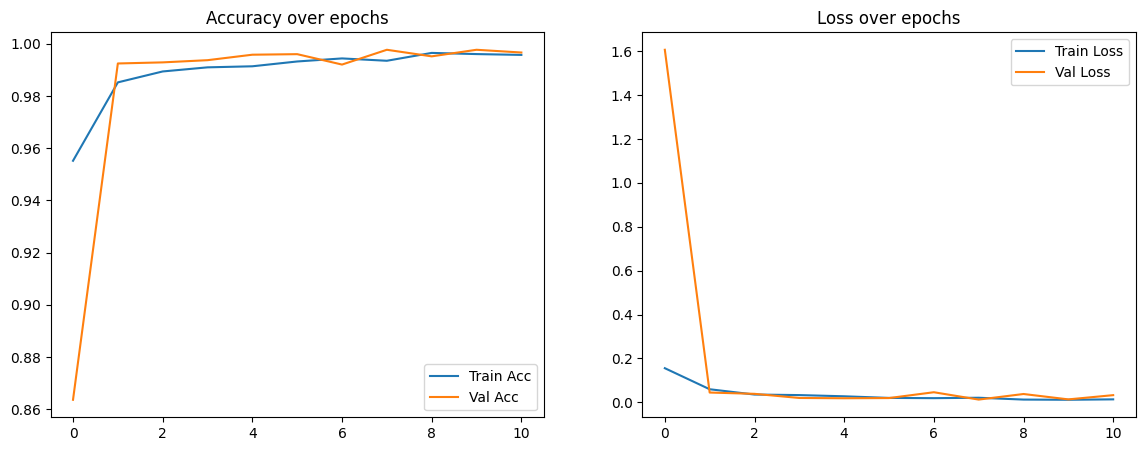

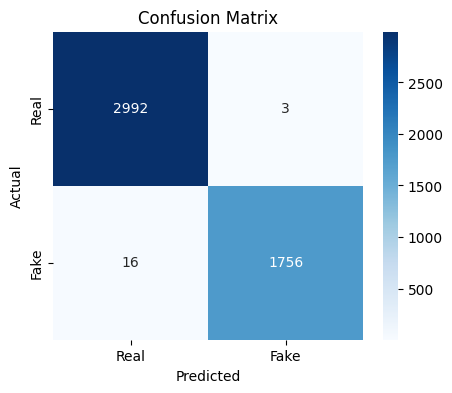

In [9]:
# ===============================
# STEP 9: PLOTS
# ===============================
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy over epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over epochs')
plt.legend()
plt.show()

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real','Fake'], yticklabels=['Real','Fake'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [12]:
model.save("/kaggle/working/deepfake_audio_cnn_model.h5")
print(" Model saved in .h5 format!")


 Model saved in .h5 format!


In [13]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model("/kaggle/working/deepfake_audio_cnn_model.h5")

# Verify it's loaded
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 94, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 94, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 47, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 23, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 23, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 22528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,883,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,977,411 (11.36 MB)

 Trainable params: 2,976,961 (11.36 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 2 (12.00 B)